<a href="https://colab.research.google.com/github/tzopiz/TMJ/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# colab не может найти зависимость
# !pip install -r requirements.txt

In [2]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations as A
import numpy as np
import torch

from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2

from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from train import (
    CheckpointSaver,
    load_checkpoint,
    train
)

from MeanIoU import MeanIoU
from DiceLoss import DiceLoss
from TMJDataset import TMJDataset
from unet import UNet

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

In [4]:
# Определяем размер изображения
IMAGE_SIZE = 512  # Или любой другой размер

# Группировка базовых преобразований
basic_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),  # Изменение размера
    A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, p=1.0),  # Добавление паддинга
    A.CropNonEmptyMaskIfExists(height=IMAGE_SIZE, width=IMAGE_SIZE),  # Обрезка
    A.HorizontalFlip(p=0.5),  # Случайный горизонтальный флип
])

# Группировка агрессивных преобразований
aggressive_transforms = A.Compose([
    A.OneOf([
        A.AdvancedBlur(p=0.5),  # Размытие
        A.GaussNoise(p=0.5),  # Шум Гаусса
        A.CLAHE(p=0.5),  # CLAHE
    ], p=0.5),  # Применяется с вероятностью 30%

    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),  # Случайная яркость и контраст
        A.RandomGamma(p=0.5),  # Случайная гамма
        A.ColorJitter(p=0.5),  # Случайное изменение яркости, контраста и насыщенности
    ], p=0.5),  # Применяется с вероятностью 30%

    A.Rotate(limit=20, p=0.5),  # Случайный поворот
])

# Итоговая трансформация, где сначала применяются базовые, затем агрессивные
transforms = A.Compose([
    basic_transforms,  # Базовые преобразования
    aggressive_transforms,  # Агрессивные преобразования
    ToTensorV2(),  # Преобразование в тензор
])

In [5]:
full_dataset = TMJDataset(
    image_dir="full_dataset/images",
    mask_dir="full_dataset/masks",
    transforms=transforms
)

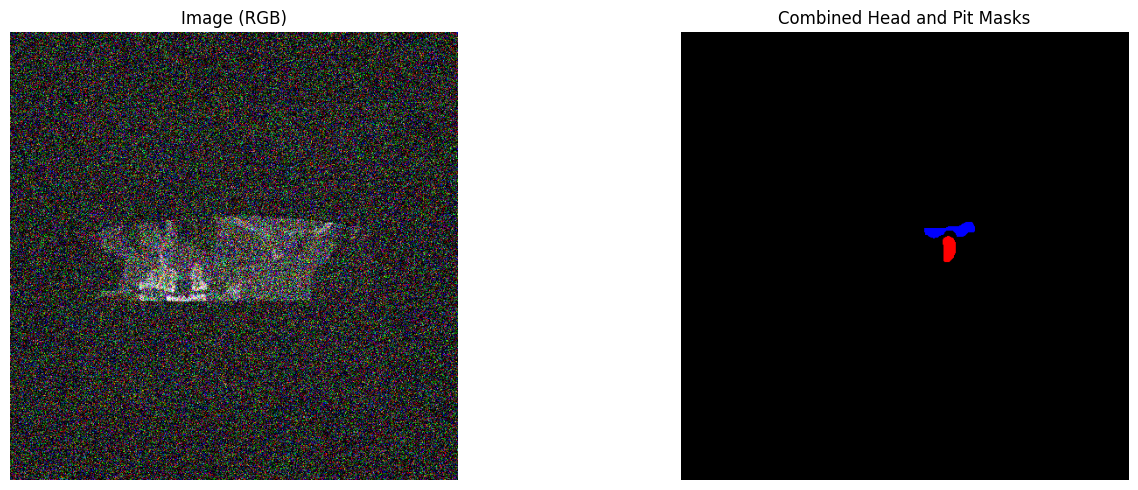

In [6]:
full_dataset.visualize(1)

In [7]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))

Количество изображений в полном датасете: 163
Количество изображений в тренировочном датасете: 114
Количество изображений в валидационном датасете: 32
Количество изображений в тестовом датасете: 17


## Обучение модели

In [8]:
CLASSES_NUM = 2

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BETAS = (0.9, 0.999)
BATCH_SIZE = 8
NUM_WORKERS = 4
EPOCH_NUM = 30
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

accelerator = Accelerator(cpu=False, mixed_precision="fp16")
model = UNet(in_channels=3, out_channels=CLASSES_NUM)

loss_fn = DiceLoss()
metric_fn = MeanIoU()

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=10, gamma=0.85
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="mIoU",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [11]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
    show_every_x_batch=15,
)

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------
Epoch 0/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.98259
Epoch train metric: 0.01113


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.98719
Epoch validation metric: 0.00968
Best epoch mIoU value is 0.0097 on 0 epoch
------------------------------
Epoch 1/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.97734
Epoch train metric: 0.01703


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.97837
Epoch validation metric: 0.01627
Best epoch mIoU value is 0.0163 on 1 epoch
------------------------------
Epoch 2/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.97500
Epoch train metric: 0.01791


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.97659
Epoch validation metric: 0.01640
Best epoch mIoU value is 0.0164 on 2 epoch
------------------------------
Epoch 3/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.97343
Epoch train metric: 0.02247


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.97282
Epoch validation metric: 0.01348
Best epoch mIoU value is 0.0164 on 2 epoch
------------------------------
Epoch 4/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.97291
Epoch train metric: 0.03497


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96917
Epoch validation metric: 0.02827
Best epoch mIoU value is 0.0283 on 4 epoch
------------------------------
Epoch 5/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96953
Epoch train metric: 0.06546


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96568
Epoch validation metric: 0.09442
Best epoch mIoU value is 0.0944 on 5 epoch
------------------------------
Epoch 6/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96848
Epoch train metric: 0.06885


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.97109
Epoch validation metric: 0.08767
Best epoch mIoU value is 0.0944 on 5 epoch
------------------------------
Epoch 7/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96712
Epoch train metric: 0.07804


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96802
Epoch validation metric: 0.03573
Best epoch mIoU value is 0.0944 on 5 epoch
------------------------------
Epoch 8/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96618
Epoch train metric: 0.06969


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96641
Epoch validation metric: 0.04168
Best epoch mIoU value is 0.0944 on 5 epoch
------------------------------
Epoch 9/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96436
Epoch train metric: 0.07605


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96334
Epoch validation metric: 0.11607
Best epoch mIoU value is 0.1161 on 9 epoch
------------------------------
Epoch 10/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96399
Epoch train metric: 0.07695


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96606
Epoch validation metric: 0.04467
Best epoch mIoU value is 0.1161 on 9 epoch
------------------------------
Epoch 11/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96096
Epoch train metric: 0.08994


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96485
Epoch validation metric: 0.13430
Best epoch mIoU value is 0.1343 on 11 epoch
------------------------------
Epoch 12/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96184
Epoch train metric: 0.08521


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96872
Epoch validation metric: 0.03845
Best epoch mIoU value is 0.1343 on 11 epoch
------------------------------
Epoch 13/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96038
Epoch train metric: 0.09702


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.96751
Epoch validation metric: 0.12224
Best epoch mIoU value is 0.1343 on 11 epoch
------------------------------
Epoch 14/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.96042
Epoch train metric: 0.08260


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95808
Epoch validation metric: 0.15778
Best epoch mIoU value is 0.1578 on 14 epoch
------------------------------
Epoch 15/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.95971
Epoch train metric: 0.10662


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95860
Epoch validation metric: 0.06853
Best epoch mIoU value is 0.1578 on 14 epoch
------------------------------
Epoch 16/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.95588
Epoch train metric: 0.08928


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95912
Epoch validation metric: 0.15493
Best epoch mIoU value is 0.1578 on 14 epoch
------------------------------
Epoch 17/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.95453
Epoch train metric: 0.09591


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95135
Epoch validation metric: 0.10424
Best epoch mIoU value is 0.1578 on 14 epoch
------------------------------
Epoch 18/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.95142
Epoch train metric: 0.12655


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95061
Epoch validation metric: 0.17513
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 19/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94919
Epoch train metric: 0.12602


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95507
Epoch validation metric: 0.08251
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 20/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94794
Epoch train metric: 0.12396


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95332
Epoch validation metric: 0.15448
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 21/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94847
Epoch train metric: 0.11434


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95492
Epoch validation metric: 0.17095
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 22/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94815
Epoch train metric: 0.12033


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.95347
Epoch validation metric: 0.06872
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 23/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94520
Epoch train metric: 0.11862


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.94705
Epoch validation metric: 0.12821
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 24/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94423
Epoch train metric: 0.12395


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.94841
Epoch validation metric: 0.05898
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 25/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.94370
Epoch train metric: 0.10367


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.93706
Epoch validation metric: 0.16103
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 26/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.93976
Epoch train metric: 0.12670


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.94226
Epoch validation metric: 0.11724
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 27/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.93771
Epoch train metric: 0.13260


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.93650
Epoch validation metric: 0.12784
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 28/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.93458
Epoch train metric: 0.13140


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.94472
Epoch validation metric: 0.10018
Best epoch mIoU value is 0.1751 on 18 epoch
------------------------------
Epoch 29/30


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch train loss: 0.93178
Epoch train metric: 0.12765


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch validation loss: 0.93731
Epoch validation metric: 0.19182
Best epoch mIoU value is 0.1918 on 29 epoch


In [13]:
model = UNet(in_channels=3, out_channels=CLASSES_NUM)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval();

/content/train.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=torch.device("cpu"))


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, index, device, threshold=0.5):
    # Загружаем изображение и маску
    image, mask = dataset[index]

    # Получаем предсказания модели
    logits = model(image.unsqueeze(0).to(device)).squeeze(0)

    # Преобразуем изображение в numpy
    image = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Разделяем маску на два канала
    head_mask = mask[0].cpu().numpy()
    pit_mask = mask[1].cpu().numpy()

    # Предсказанные маски
    head_mask_logits = logits[0].cpu().detach().numpy()
    pit_mask_logits = logits[1].cpu().detach().numpy()

    # Создаем фигуру для визуализации
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Визуализируем изображение
    axes[0].imshow(image)
    axes[0].set_title("Image (RGB)")

    # Визуализируем истинную маску (красный — головка, синий — ямка)
    combined_mask = np.zeros((head_mask.shape[0], head_mask.shape[1], 3), dtype=np.uint8)
    combined_mask[head_mask == 1] = [255, 0, 0]  # Красный для головки
    combined_mask[pit_mask == 1] = [0, 0, 255]  # Синий для ямки
    axes[1].imshow(combined_mask)
    axes[1].set_title("Ground Truth Mask")

    # Визуализируем предсказанную моделью маску
    combined_mask_pred = np.zeros((head_mask.shape[0], head_mask.shape[1], 3), dtype=np.uint8)
    combined_mask_pred[head_mask_logits > threshold] = [255, 0, 0]
    combined_mask_pred[pit_mask_logits > threshold] = [0, 0, 255]
    axes[2].imshow(combined_mask_pred)
    axes[2].set_title("Prediction")

    plt.tight_layout()
    plt.show()




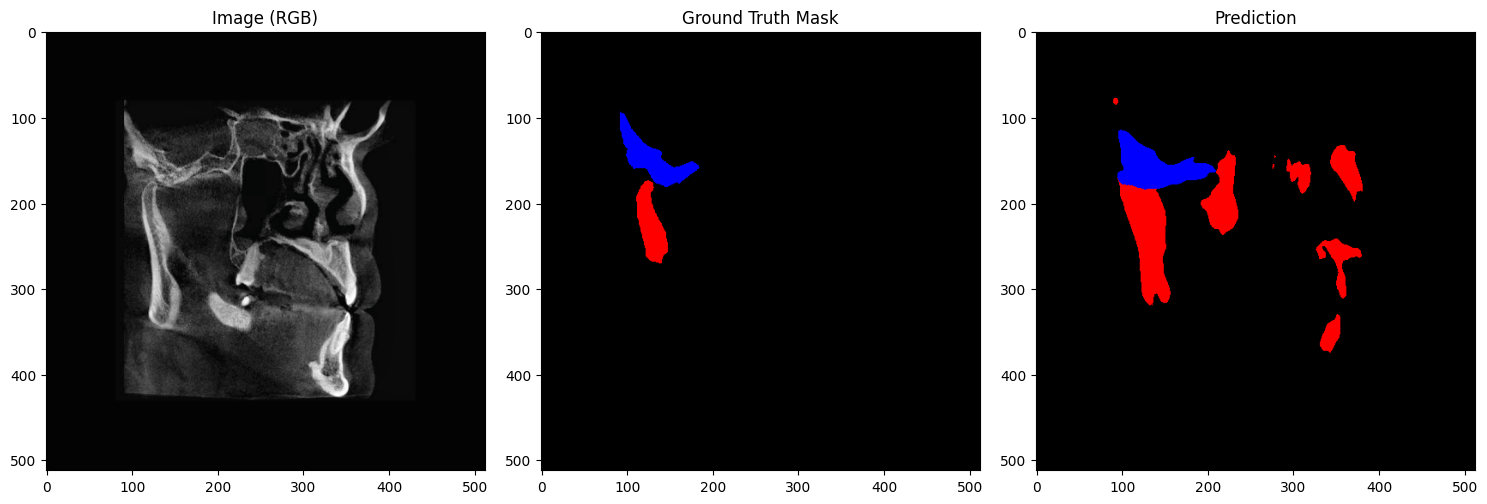

In [64]:
visualize_prediction(
    model=model,
    dataset=test_dataset,
    index=1,
    device=DEVICE,
    threshold=0.99
)